In [ ]:
!pip install -Uq gpytorch

In [ ]:
import tqdm
import math
import torch
import numpy as np

import torch.distributions as dist

import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

# Code

In [ ]:
import math
from numbers import Number, Real

import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all


class CensoredNormal(ExponentialFamily):
    """
    Creates a censored normal (also called Gaussian) distribution parameterized by
    :attr:`loc` and :attr:`scale` and :attr:`low`  and :attr:`high`

    Example::

        >>> # xdoctest: +IGNORE_WANT("non-deterministic")
        >>> m = CensoredNormal(
          torch.tensor([0.0]), torch.tensor([1.0]),
          torch.tensor([-0.5]), torch.tensor([0.5])
          )
        >>> m.sample(sample_shape=(3,1))
        tensor([[0.5000],
            [0.5000],
            [0.1836]])
        tensor([ 0.1046])

    Args:
        loc (float or Tensor): mean of the base normal distribution (often referred to as mu) to which the censoring is applied
        scale (float or Tensor): standard deviation of the base normal distribution to which the censoring is applied
        low (float or Tensor): lower censoring boundary
        high (float or Tensor): upper censoring boundary
    """
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "low": constraints.dependent(is_discrete=False, event_dim=0),
        "high": constraints.dependent(is_discrete=False, event_dim=0)}
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = pdf_high - pdf_low
        return self.loc * term1 - self.scale * term2

    @property
    def stddev(self):
        return self.variance.sqrt()

    @property
    def variance(self):
        x_high = (self.high - self.loc)/self.scale
        cdf_high = self._normal_cdf(self.high)
        pdf_high = math.exp(self._normal_log_prob(self.high))
        x_low = (self.low - self.loc)/self.scale
        cdf_low = self._normal_cdf(self.low)
        pdf_low = math.exp(self._normal_log_prob(self.low))
        term1 = cdf_high - cdf_low
        term2 = x_high * pdf_high - x_low * pdf_low
        return  (self.scale ** 2) * (term1 - term2)


    def __init__(self, loc, scale, low, high, validate_args=None):
        self.loc, self.scale, self.low, self.high = broadcast_all(loc, scale, low, high)
        if isinstance(loc, Number) and isinstance(scale, Number) and isinstance(low, Number) and isinstance(high, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        support = constraints.interval(low, high)
        super().__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(CensoredNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.low = self.low.expand(batch_shape)
        new.high = self.high.expand(batch_shape)
        super(CensoredNormal, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    @constraints.dependent_property(is_discrete=False, event_dim=0)
    def support(self):
        return constraints.interval(self.low, self.high)


    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            samples = torch.normal(self.loc.expand(shape), self.scale.expand(shape))
            return samples.clamp(min=self.low, max=self.high)


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        rsamples =  self.loc + eps * self.scale
        return rsamples.clamp(min=self.low, max=self.high)

    def pdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        probs = torch.exp(self.log_prob(value))
        lower_cdf_mass = self._normal_cdf(self.low)
        upper_cdf_mass = 1 - self._normal_cdf(self.high)
        probs = torch.where(value <= self.low, lower_cdf_mass, probs)
        probs = torch.where(value >= self.high, upper_cdf_mass, probs)
        return probs

    def log_prob(self, value, jitter=1e-12):
        """jitter: used to bounce off NormCDF from 0 before applying log """
        if self._validate_args:
            self._validate_sample(value)
        log_probs = self._normal_log_prob(value)
        lower_log_cdf_mass = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                Number) else (self._normal_cdf(self.low) + jitter).log()
        upper_log_cdf_mass = math.log(1 - self._normal_cdf(self.high) + jitter) if isinstance(1 - self._normal_cdf(self.high) + jitter,
                                                                                                    Number) else (1 - self._normal_cdf(self.high) + jitter).log()
        log_probs = torch.where(value <= self.low, lower_log_cdf_mass, log_probs)
        log_probs = torch.where(value >= self.high, upper_log_cdf_mass, log_probs)
        return log_probs

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        cdf_ = self._normal_cdf(value)
        cdf_ = torch.where(value < self.low, 0, cdf_)
        cdf_ = torch.where(value > self.high, 1, cdf_)
        return cdf_

    def icdf(self, value):
        result = self._normal_icdf(value)
        return result.clamp(min=self.low, max=self.high)

    def entropy(self, jitter=1e-12):
        x_low = (self.low - self.loc)/self.scale
        x_high = (self.high - self.loc)/self.scale

        logcdf_x_low = math.log(self._normal_cdf(self.low) + jitter) if isinstance(self._normal_cdf(self.low) + jitter,
                                                                                                  Number) else (self._normal_cdf(self.low) + jitter).log()
        logcdf_x_high = math.log(self._normal_cdf_standardized(-x_high) + jitter) if isinstance(self._normal_cdf_standardized(x_high) + jitter,
                                                                                                      Number) else (self._normal_cdf_standardized(-x_high) + jitter).log()

        term1 = self._normal_entropy() * (self._normal_cdf(self.high)- self._normal_cdf(self.low))
        term2 = 0.5 * (x_high * torch.exp(self._normal_log_prob(self.high)) - x_low * torch.exp(self._normal_log_prob(self.low)))
        term3 = logcdf_x_low * self._normal_cdf(self.low)
        term4 = logcdf_x_high * (self._normal_cdf_standardized(-x_high))
        return term1 - term2 - term3 - term4


    def _normal_log_prob(self, value):
            # compute the variance
            var = self.scale**2
            log_scale = (
                math.log(self.scale) if isinstance(self.scale, Real) else self.scale.log()
            )
            return (
                -((value - self.loc) ** 2) / (2 * var)
                - log_scale
                - math.log(math.sqrt(2 * math.pi))
            )

    def _normal_cdf(self, value):
        return 0.5 * (
            1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2))
        )

    def _normal_cdf_standardized(self, z):
        return 0.5 * (
            1 + torch.erf(z / math.sqrt(2))
        )

    def _normal_icdf(self, value):
        return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)


    def _normal_entropy(self):\
        # log(sqrt(2 pi e) * sigma) = 0.5 * log(2 pi e) + log(sigma) = 0.5 + 0.5 (log(2 pi)) + log(sigma)
        return 0.5 + 0.5 * math.log(2 * math.pi) + torch.log(self.scale)

    @property
    def _normal_natural_params(self):
        return (self.loc / self.scale.pow(2), -0.5 * self.scale.pow(2).reciprocal())

    def _log_normalizer(self, x, y):
        return -0.25 * x.pow(2) / y + 0.5 * torch.log(-math.pi / y)

In [ ]:
import warnings
from typing import Any

import torch
from linear_operator.operators import LinearOperator, ZeroLinearOperator
from torch import Tensor
from torch.distributions import Distribution, Normal

from gpytorch.constraints import Interval
from gpytorch.distributions import base_distributions, MultivariateNormal
from gpytorch.priors import Prior
from gpytorch.utils.warnings import GPInputWarning
from gpytorch.likelihoods.likelihood import _Likelihood, _OneDimensionalLikelihood


class CensoredGaussianLikelihood(_Likelihood):
    """Base class for Censored Gaussian Likelihoods."""
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.noise = gpytorch.likelihoods.noise_models.HomoskedasticNoise()
        self.noise.initialize(noise=variance)
        self.low = low
        self.high = high

    @property
    def variance(self):
      return self.noise.noise

    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any):
        return CensoredNormal(function_samples, scale=self.variance.sqrt(), low=self.low, high=self.high)

class CensoredGaussianLikelihoodMathematica(CensoredGaussianLikelihood):
    def __init__(self, variance=None, low=None, high=None) -> None:
        super().__init__(variance, low, high)

    def expected_log_prob(self, target: Tensor, input: MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        noise = self.variance # likelihood
        mean, variance = input.mean, input.variance # approximate posterior

        jitter_=1e-16

        upper_censor = lambda x, s: (self.high - x) / s
        lower_censor = lambda x, s: (self.low - x) / s

        standard_normal = dist.Normal(0,1)
         # Gaussian term
        term1 = 2. + torch.log(noise) + math.log(2 * math.pi)
        term2 = ((target - mean).square() + variance) * noise.reciprocal()
        term3 = standard_normal.cdf(upper_censor(mean, variance.sqrt())) - standard_normal.cdf(lower_censor(mean, variance.sqrt()))
        normal_part_unscaled = (term1 - term2).mul(0.5)
        normal_part = normal_part_unscaled * term3

        # upper term
        x1 = (self.high - 2*target + mean) * variance.sqrt()
        term4 = torch.clamp_min(standard_normal.cdf(-upper_censor(target, variance.sqrt())), jitter_).log() + 0.5 * x1 * noise.reciprocal()
        upper_censored_part = term4 * standard_normal.log_prob(upper_censor(mean, variance.sqrt())).exp()

        # lower term
        x2 = (self.low - 2*target + mean) * variance.sqrt()
        term5 = torch.clamp_min(standard_normal.cdf(lower_censor(target, variance.sqrt())), jitter_).log() - 0.5 * x2 * noise.reciprocal()
        lower_censored_part = term5 * standard_normal.log_prob(lower_censor(mean, variance.sqrt())).exp()

        res = normal_part - lower_censored_part - upper_censored_part
        return res

class CensoredGaussianLikelihoodAnalytic(CensoredGaussianLikelihood):
    def __init__(self, variance=None, low=None, high=None, alpha=1., gamma=1., dzeta=1., jitter_=1e-16) -> None:
        super().__init__(variance, low, high)
        self.alpha = alpha
        self.gamma = gamma
        self.dzeta = dzeta
        self.jitter_ = jitter_

    def expected_log_prob(self, target: Tensor, input: MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        noise = self.variance # likelihood
        mean, variance = input.mean, input.variance # approximate posterior

        upper_censor = lambda x, s: (self.high - x) / s
        lower_censor = lambda x, s: (self.low - x) / s

        standard_normal = dist.Normal(0,1)
         # Gaussian term
        term1 = torch.log(noise) + math.log(2 * math.pi)
        term2 = ((target - mean).square() + variance) * noise.reciprocal()
        term3 = standard_normal.cdf(upper_censor(mean, variance.sqrt())) - standard_normal.cdf(lower_censor(mean, variance.sqrt()))
        normal_part_unscaled = (term1 - term2).mul(0.5)
        normal_part = normal_part_unscaled * term3

        # upper term
        x1 = (self.high - 2*target + mean) * variance.sqrt()
        term4 = torch.clamp_min(standard_normal.cdf(-upper_censor(target, variance.sqrt())), self.jitter_).log() + 0.5 * x1 * noise.reciprocal()
        upper_censored_part = term4 * standard_normal.log_prob(upper_censor(mean, variance.sqrt())).exp()

        # lower term
        x2 = (self.low - 2*target + mean) * variance.sqrt()
        term5 = torch.clamp_min(standard_normal.cdf(lower_censor(target, variance.sqrt())), self.jitter_).log() - 0.5 * x2 * noise.reciprocal()
        lower_censored_part = term5 * standard_normal.log_prob(lower_censor(mean, variance.sqrt())).exp()

        res = self.alpha * normal_part - self.gamma * upper_censored_part - self.dzeta * lower_censored_part
        return res

In [ ]:
def rgetattr(o, k_list):
  for k in k_list:
    o = getattr(o,k)
  return o

def print_module(module):
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      print(f'{name:35} {tuple(param.shape)}\n{param.numpy().round(10)}')

def get_module(module):
  ret = {}
  with torch.no_grad():
    for name, _ in module.named_parameters():
      name = name.replace('raw_','')
      param = rgetattr(module, name.split('.'))
      ret[name] = param.numpy()
  return ret

In [ ]:
def branin_hoo(x):
    """
    Branin-Hoo test function (2d)
    http://www.sfu.ca/~ssurjano/branin.html
    """
    x1 = x[:,0]
    x2 = x[:,1]
    try:
        x1 = x1.numpy()
        x2 = x2.numpy()
    except:
        pass
    x1 = 15 * x1 - 5
    x2 = 15 * x2
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6
    s = 10
    t = 1/(8 * np.pi)
    v = (x2 - b*x1**2 + c*x1 - r)**2 + s * (1 - t) * np.cos(x1) + s
    if isinstance(x, torch.Tensor):
        return torch.FloatTensor(v)
    else:
        return v

In [ ]:
MAX_VALUE= 10.0

def oracle(x, output_noise=0.0):
    r = branin_hoo(x)
#     r = r + torch.randn(r.shape)*output_noise
    r[r > MAX_VALUE] = MAX_VALUE
    return r

def oracle_binarized(x):
    r = oracle(x)
    fail = r >= MAX_VALUE
    r[fail] = 0
    r[~fail] = 1
    return r

def plot_test_function(fn):
    domain = torch.linspace(0, 1, 100)
    xx, yy = torch.meshgrid(domain, domain)
    xxyy = torch.stack((xx.ravel(), yy.ravel())).T
    zz = fn(xxyy).reshape(xx.shape)
    if zz.max() == 1.0:
        plt.contourf(xx, yy, zz)
    else:
        plt.contourf(xx, yy, zz) # , levels=2**np.arange(0, int(np.ceil(np.log2(zz.max()))), 0.5)-1)
    plt.colorbar()

# Synthetic 2D

In [ ]:
MAX_VALUE= 50.0

N_init = 10
np.random.seed(4)
x = torch.FloatTensor(np.random.rand(N_init, 2))
y = oracle(x)

# test data
domain = torch.linspace(0, 1, 100)
xx, yy = torch.meshgrid(domain, domain)
xxyy = torch.stack((xx.ravel(), yy.ravel())).T
y_test = branin_hoo(xxyy)
y_test_censored = oracle(xxyy)

# MC Simulation

In [223]:
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        # defines approximation
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = GPModel(inducing_points=x[:,:])

# ELBO Likelihood
likelihood = CensoredGaussianLikelihood(low=-1000., high=MAX_VALUE)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [224]:
print_module(model)

variational_strategy._variational_distribution.variational_mean (10,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
variational_strategy._variational_distribution.chol_variational_covar (10, 10)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
mean_module.constant                ()
0.0
covar_module.outputscale            ()
0.6931471824645996
covar_module.base_kernel.lengthscale (1, 1)
[[0.6931472]]


In [225]:
num_epochs = 1000
pbar = tqdm.tqdm(range(num_epochs), position=0, leave=True)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.001)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, beta=1., combine_terms=False, num_data=y.size(0))

params_log = dict()
metrics = dict()
for iter in pbar:
    optimizer.zero_grad()
    y_pred = model(x)
    log_likelihood, kl_divergence, log_prior  = mll(y_pred, y)
    loss = -(log_likelihood - kl_divergence + log_prior)
    loss.backward()
    optimizer.step()
    params_log[iter] = {
        'loss': loss.item(),
        'log_likelihood': log_likelihood.item(),
        'kl_divergence': kl_divergence.item(),
        'log_prior': log_prior.item(),
        'outscale': model.covar_module.outputscale.item(),
        'mean_module': model.mean_module.constant.item(),
        'noise': likelihood.noise.noise.item()
        }

    if iter%100==0:
      for key, val in params_log[iter].items():
        print(key, val)

      model.eval()
      likelihood.eval()
      metrics[iter] = {
        'mae': gpytorch.metrics.mean_absolute_error(model(xxyy), y_test).numpy(force=True),
        'posterior_log_prob': model(xxyy).log_prob(y_test).mean().numpy(force=True),
        'npld_posterior': gpytorch.metrics.negative_log_predictive_density(model(xxyy), y_test).mean().numpy(force=True),
        'npld_predictive_posterior': gpytorch.metrics.negative_log_predictive_density(likelihood(model(xxyy)), y_test_censored).mean().numpy(force=True)
      }
      model.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

loss 127.36061096191406
log_likelihood -127.36061096191406
kl_divergence 3.814697322468419e-07
log_prior 0.0
outscale 0.6936473250389099
mean_module 0.0009999999310821295
noise 1.0006321668624878


  9%|▉         | 92/1000 [00:11<00:18, 48.37it/s]

loss 120.98335266113281
log_likelihood -120.97773742675781
kl_divergence 0.0056175231002271175
log_prior 0.0
outscale 0.6999161243438721
mean_module 0.09962145239114761
noise 1.063735842704773


 19%|█▉        | 193/1000 [00:26<00:19, 40.85it/s]

loss 104.3643798828125
log_likelihood -104.34468078613281
kl_divergence 0.019702482968568802
log_prior 0.0
outscale 0.7304108142852783
mean_module 0.19481444358825684
noise 1.1256855726242065


 30%|██▉       | 295/1000 [00:38<00:15, 46.00it/s]

loss 103.5870132446289
log_likelihood -103.54713439941406
kl_divergence 0.039876364171504974
log_prior 0.0
outscale 0.7789132595062256
mean_module 0.28693366050720215
noise 1.1864757537841797


 40%|███▉      | 395/1000 [00:56<00:16, 36.68it/s]

loss 96.79850769042969
log_likelihood -96.73197937011719
kl_divergence 0.06652688980102539
log_prior 0.0
outscale 0.8428295850753784
mean_module 0.3762173056602478
noise 1.2459537982940674


 50%|████▉     | 496/1000 [01:17<00:15, 33.18it/s]

loss 92.59197998046875
log_likelihood -92.49287414550781
kl_divergence 0.0991055965423584
log_prior 0.0
outscale 0.9137703776359558
mean_module 0.46304458379745483
noise 1.3042817115783691


 60%|█████▉    | 595/1000 [01:36<00:11, 34.05it/s]

loss 86.28764343261719
log_likelihood -86.15225982666016
kl_divergence 0.13538627326488495
log_prior 0.0
outscale 0.9907511472702026
mean_module 0.5475298762321472
noise 1.3614598512649536


 70%|██████▉   | 697/1000 [01:57<00:09, 33.46it/s]

loss 80.14679718017578
log_likelihood -79.97054290771484
kl_divergence 0.17625756561756134
log_prior 0.0
outscale 1.0723137855529785
mean_module 0.6299652457237244
noise 1.4175087213516235


 80%|████████  | 800/1000 [02:19<00:05, 39.01it/s]

loss 72.88093566894531
log_likelihood -72.66071319580078
kl_divergence 0.22022275626659393
log_prior 0.0
outscale 1.1598963737487793
mean_module 0.7103492021560669
noise 1.4722918272018433


 89%|████████▉ | 894/1000 [02:44<00:03, 30.04it/s]

loss 72.12657928466797
log_likelihood -71.85956573486328
kl_divergence 0.26701563596725464
log_prior 0.0
outscale 1.253076195716858
mean_module 0.7887707352638245
noise 1.5257114171981812


100%|██████████| 1000/1000 [03:08<00:00,  5.31it/s]


['loss', 'log_likelihood', 'kl_divergence', 'outscale', 'mean_module', 'noise', 'mae', 'posterior_log_prob', 'npld_predictive_posterior']


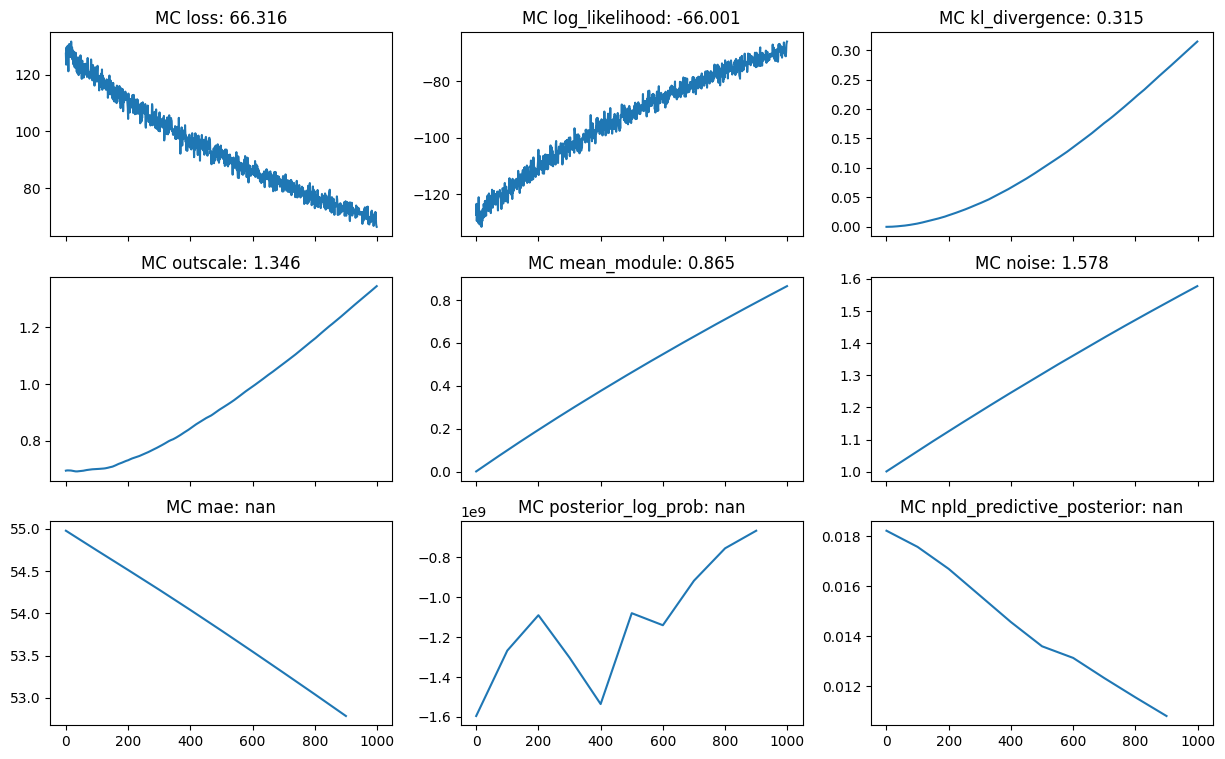

In [226]:
params_mc_benchmark = pd.DataFrame(params_log).T
metrics_mc_benchmark = pd.DataFrame(metrics).T
mc_benchmark_eval = pd.concat([params_mc_benchmark, metrics_mc_benchmark], axis=1)
cols = mc_benchmark_eval.columns.to_list()
cols.remove('log_prior')
cols.remove('npld_posterior')
print(cols)

fig, ax = plt.subplots(3,3, figsize=(15,9), sharex=True)
for col_, ax_ in zip(cols, ax.flatten()):
  mc_benchmark_eval[col_].dropna().astype('float').plot(title='MC %s: %.3f'%(col_,  mc_benchmark_eval[col_].tail(1).values[0]), ax=ax_)

In [ ]:
print_module(likelihood)
print_module(model)

noise.noise                         (1,)
[11.125744]
variational_strategy._variational_distribution.variational_mean (10,)
[ 6.400436    1.9366412   2.2074926  -1.4543812   0.90068144  0.13198599
  0.3564981  -2.5290282   0.9574743  -0.5894147 ]
variational_strategy._variational_distribution.chol_variational_covar (10, 10)
[[ 0.23891531  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.08981812  0.9432278   0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.29867676  0.21487473  0.6141175   0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.43420658  0.48207474  0.51796633  0.92636496  0.          0.
   0.          0.          0.          0.        ]
 [ 0.34470406  0.2366301   0.17980556  0.5591451   0.47662365  0.
   0.          0.          0.          0.        ]
 [ 0.05346302  0.06098251  0.42644227 -0.02592748  0.04994186  0.9783382
   0.          0.

In [227]:
model.eval()
likelihood.eval()

domain = torch.linspace(0, 1, 100)
xx, yy = torch.meshgrid(domain, domain)
xxyy = torch.stack((xx.ravel(), yy.ravel())).T

f_preds = model(xxyy)
y_preds = likelihood(f_preds)

f_mean = f_preds.loc
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

# N_samples = 1000
# breakpoints = torch.linspace(0, 100, N_samples+1)[:-1]
# breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)
# xx_, yy_ = torch.meshgrid(domain, domain)
# xxyy_breakpoints = torch.stack((xx.ravel(), yy.ravel())).T

# with torch.no_grad():
#     pred_samples = torch.distributions.MultivariateNormal(f_mean, f_covar).icdf(breakpoints[:,None])

In [ ]:
# y_test = branin_hoo(xxyy)
# model(xxyy).log_prob(y_test).mean().numpy(force=True)
# nlpd_posterior = gpytorch.metrics.negative_log_predictive_density(model(xxyy), y_test).mean().numpy(force=True)

# y_test = branin_hoo(xxyy)
# y_test_censored = oracle(xxyy)
# nlpd_predictive_post = gpytorch.metrics.negative_log_predictive_density(likelihood(model(xxyy)), y_test_censored).mean().numpy(force=True)

# print('nlpd posterior: ', nlpd_posterior, 'nlpd predictive posterior: ', nlpd_predictive_post)

(0.0, 1.0, 0.0, 1.0)

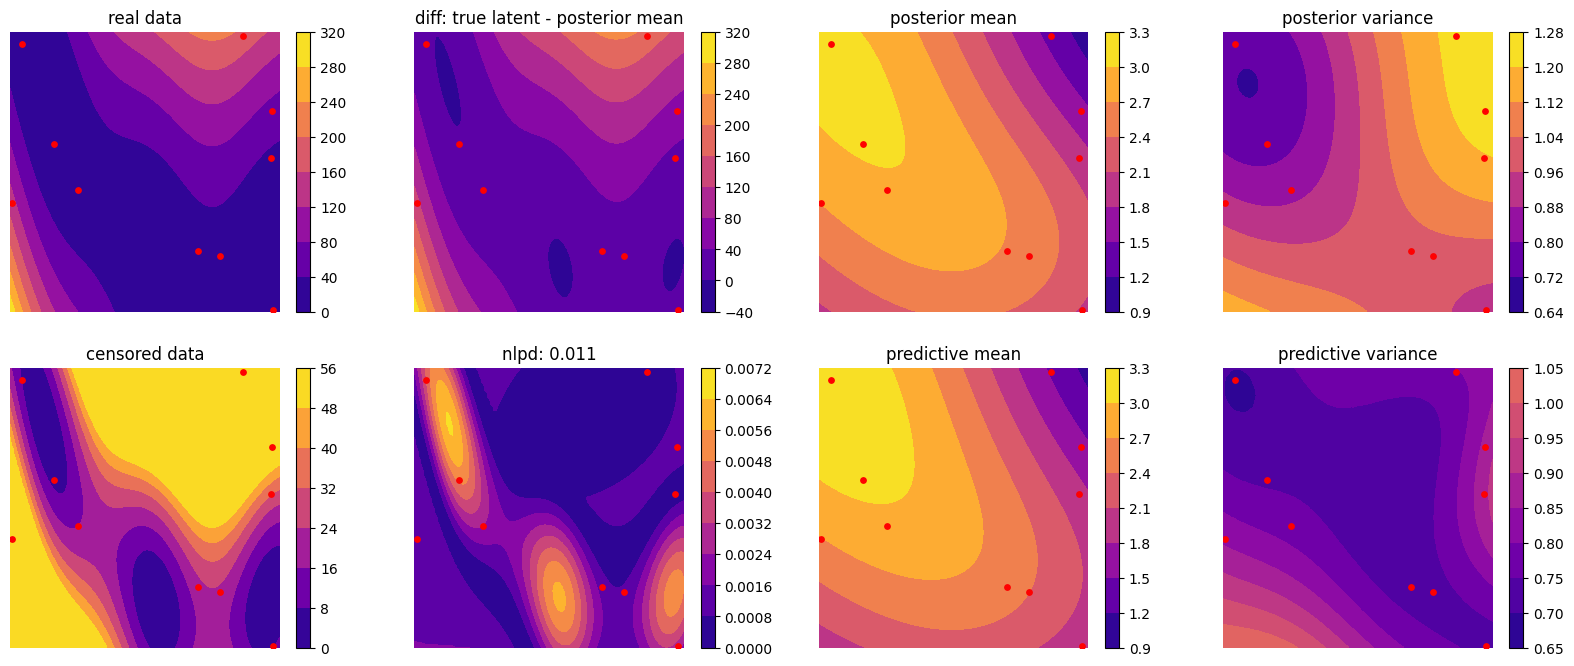

In [239]:
fig, ax = plt.subplots(2,4, figsize=(20, 8))
# plt.set_cmap(cmap='Purples_r')
plt.set_cmap(cmap='plasma')

#kwargs = dict(vmin=0, vmax=320)

zz = branin_hoo(xxyy).reshape(xx.shape)
#cs0 = ax[0,0].contourf(xx, yy, zz, **kwargs)
cs0 = ax[0,0].contourf(xx, yy, zz,)
ax[0,0].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[0,0].set_title('real data')
fig.colorbar(cs0)
ax[0,0].axis('off')

zz = oracle(xxyy).reshape(xx.shape)
cs1 = ax[1,0].contourf(xx, yy, zz)
ax[1,0].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[1,0].set_title('censored data')
fig.colorbar(cs1)
ax[1,0].axis('off')

zz = branin_hoo(xxyy).reshape(xx.shape) - f_mean.numpy(force=True).reshape(xx.shape)
cs2 = ax[0,1].contourf(xx, yy, zz)
ax[0,1].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[0,1].set_title('diff: true latent - posterior mean')
fig.colorbar(cs2)
ax[0,1].axis('off')

zz = f_mean.numpy(force=True).reshape(xx.shape)
cs3 = ax[0,2].contourf(xx, yy, zz)
ax[0,2].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[0,2].set_title('posterior mean')
fig.colorbar(cs3)
ax[0,2].axis('off')

zz = f_var.numpy(force=True).reshape(xx.shape)
cs4 = ax[0,3].contourf(xx, yy, zz)
ax[0,3].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[0,3].set_title('posterior variance')
fig.colorbar(cs4)
ax[0,3].axis('off')

final_nldp = gpytorch.metrics.negative_log_predictive_density(likelihood(model(xxyy)), y_test_censored).mean().numpy(force=True)
zz = final_nlpd.reshape([10,xx.shape[0],xx.shape[1]]).mean(0).numpy(force=True)
cs5 = ax[1,1].contourf(xx, yy, zz)
ax[1,1].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[1,1].set_title('nlpd: %.3f'%(final_nldp))
fig.colorbar(cs5)
ax[1,1].axis('off')


zz = f_preds.sample_n(n=100).mean(0).numpy(force=True).reshape(xx.shape)
cs6 = ax[1,2].contourf(xx, yy, zz)
cmin, cmax = cs3.get_clim()
cs6.set_clim(cmin, cmax)
ax[1,2].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[1,2].set_title('predictive mean')
fig.colorbar(cs6)
ax[1,2].axis('off')

zz = f_preds.sample_n(n=100).var(0).numpy(force=True).reshape(xx.shape)
cs7 = ax[1,3].contourf(xx, yy, zz)
cmin1, cmax1 = cs4.get_clim()
cs7.set_clim(cmin1, cmax1)
ax[1,3].scatter(x[:,0], x[:,1], s=60, marker='.', color='r')
ax[1,3].set_title('predictive variance')
fig.colorbar(cs7)
ax[1,3].axis('off')
